In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import compute_class_weight
from sklearn.metrics import f1_score
from collections import Counter
%matplotlib inline

Read the dataset

In [2]:
sessions_df = pd.read_json('catchjoe/dataset.json')

View the dataset info

In [3]:
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 9 columns):
browser     80000 non-null object
date        80000 non-null datetime64[ns]
gender      80000 non-null object
locale      80000 non-null object
location    80000 non-null object
os          80000 non-null object
sites       80000 non-null object
time        80000 non-null object
user_id     80000 non-null int64
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 5.5+ MB


In [4]:
# Data distribution by user_id
sessions_df.user_id.value_counts()

191    400
18     400
85     400
21     400
148    400
84     400
20     400
147    400
83     400
19     400
146    400
82     400
145    400
127    400
81     400
17     400
144    400
80     400
16     400
143    400
79     400
15     400
142    400
78     400
149    400
22     400
86     400
150    400
157    400
93     400
      ... 
96     400
32     400
159    400
95     400
102    400
39     400
174    400
103    400
110    400
46     400
173    400
109    400
45     400
172    400
108    400
44     400
171    400
107    400
43     400
170    400
106    400
42     400
169    400
105    400
41     400
168    400
104    400
40     400
167    400
0      400
Name: user_id, Length: 200, dtype: int64

In [5]:
sessions_df['session_length'] = sessions_df['sites'].apply(lambda x: sum([s['length'] for s in x]))
sessions_df['num_sites_visited'] = sessions_df['sites'].apply(lambda x: len(x))
sessions_df['hour'] = sessions_df.time.apply(lambda x: int(x.split(':')[0]))
sessions_df['average_viewed_time'] = sessions_df.sites.apply(lambda lst: np.mean([s['length'] for s in lst]) if len(lst) != 0 else 0)
#sessions_df['day_of_week'] = sessions_df.date.dt.dayofweek

Examining the session data for user 0 specifically. View the os, locale, browser, gender, and location information specific to the user

In [6]:
joe_sessions_df = sessions_df[sessions_df.user_id == 0].copy()

In [7]:
# View OS
joe_sessions_df.os.unique()

array(['Windows 10', 'Ubuntu'], dtype=object)

In [8]:
# View Gender
joe_sessions_df.gender.unique()

array(['m'], dtype=object)

In [9]:
# View Locale
joe_sessions_df.locale.unique()

array(['ru_RU'], dtype=object)

In [10]:
# View Locations
joe_sessions_df.location.unique()

array(['France/Paris', 'USA/Chicago', 'Canada/Toronto'], dtype=object)

In [11]:
# View Browsers
joe_sessions_df.browser.unique()

array(['Firefox', 'Chrome'], dtype=object)

In [12]:
# What are the most common sites viewed by user 0?
joe_sites = Counter([s['site'] for x in joe_sessions_df.sites for s in x])
joe_sites.most_common(10)

[('lenta.ru', 361),
 ('toptal.com', 359),
 ('vk.com', 352),
 ('slack.com', 351),
 ('mail.google.com', 348),
 ('youtube.com', 348),
 ('gazzettaobjects.it', 3),
 ('hibapress.com', 2),
 ('dalloz.fr', 2),
 ('free.fr', 2)]

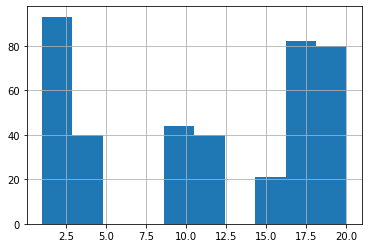

In [13]:
# What hour of day are this user's sessions happening
joe_sessions_df.hour.hist()

So it looks like sessions for user 0 have the following characteristics:
  - Gender is male
  - Uses either Firefox or Chrome browser
  - User locale is Russian
  - Uses Ubuntu or Windows 10 OS
  - Located in Paris, Chicago, or Toronto
  - Most common sites frequented are lenta.ru, toptal.com, vk.com, slack.com, mail.google.com, and youtube.com
  - Active between the hours of 1 - 3 am, 10 - 11 am, 4pm - 8pm, and 10pm

Are there any other users with similar characteristics?

In [14]:
sessions_df[(sessions_df.user_id != 0) &
            (sessions_df.gender == 'm') & 
            (sessions_df.location.isin(['France/Paris','USA/Chicago','Canada/Toronto'])) &
            (sessions_df.os.isin(['Ubuntu','Windows 10'])) &
            (sessions_df.browser.isin(['Firefox','Chrome'])) &
            (sessions_df.locale == 'ru_RU')].user_id.unique()

array([105,  82,  15, 192, 181, 111,  56,  69], dtype=int64)

What are the sites most commonly viewed by these similar users?

In [15]:
similar_users = [105,  82,  15, 192, 181, 111,  56,  69]
for user in similar_users:
    sub_df = sessions_df[sessions_df.user_id == user]
    sub_sites = Counter([s['site'] for x in sub_df.sites for s in x])
    print("User {0}: {1}".format(user, sub_sites.most_common(6)))

User 105: [('slack.com', 356), ('youtube.com', 353), ('toptal.com', 350), ('lenta.ru', 349), ('mail.google.com', 348), ('levillagedemusher.com', 3)]
User 82: [('mail.google.com', 357), ('toptal.com', 354), ('slack.com', 354), ('vk.com', 353), ('youtube.com', 349), ('lenta.ru', 345)]
User 15: [('slack.com', 352), ('youtube.com', 351), ('vk.com', 349), ('mail.google.com', 346), ('lenta.ru', 345), ('toptal.com', 345)]
User 192: [('youtube.com', 350), ('mail.google.com', 348), ('lenta.ru', 346), ('toptal.com', 346), ('vk.com', 345), ('slack.com', 341)]
User 181: [('slack.com', 371), ('vk.com', 358), ('toptal.com', 355), ('mail.google.com', 355), ('youtube.com', 355), ('lenta.ru', 350)]
User 111: [('youtube.com', 348), ('mail.google.com', 346), ('lenta.ru', 346), ('vk.com', 342), ('slack.com', 337), ('toptal.com', 335)]
User 56: [('vk.com', 347), ('lenta.ru', 344), ('toptal.com', 344), ('youtube.com', 340), ('mail.google.com', 333), ('botscanner.com', 3)]
User 69: [('mail.google.com', 357),

As we can see, these users also frequently visit the same set of sites as user 0

Since a vast majority of the users in the dataset doesn't match these chracteristics, we can safety classify these users as the negative class using a simple if then statements.

Fitting a machine learning model on the rest of the data. This will help us simplify the model while significantly reducing the class imbalance present in the data. 

In [16]:
candidate_df = sessions_df[(sessions_df.gender == 'm') & 
                            (sessions_df.location.isin(['France/Paris','USA/Chicago','Canada/Toronto'])) &
                            (sessions_df.os.isin(['Ubuntu','Windows 10'])) &
                            (sessions_df.browser.isin(['Firefox','Chrome'])) &
                            (sessions_df.locale == 'ru_RU')].reset_index()

Construct the features for the model.

Creating a binary feature that will indicate if a user has visited a site that is never visited by user 0 during the session

In [17]:
joe_sessions_df = candidate_df[candidate_df.user_id == 0].copy()
joe_sites = set()

for i in range(joe_sessions_df.shape[0]):
    site_visits = [s['site'] for s in joe_sessions_df.iloc[i]['sites']]
    for site in site_visits:
        joe_sites.add(site)
others_df = candidate_df[candidate_df.user_id != 0].copy()
non_sites = set()
for i in range(others_df.shape[0]):
    site_visits = [s['site'] for s in others_df.iloc[i]['sites']]
    for site in site_visits:
        if site not in joe_sites:
            non_sites.add(site)

In [18]:
def in_joe_blacklist(sites):
    for site in sites:
        if site['site'] in non_sites:
            return 1
    return 0
candidate_df['in_blacklist'] = candidate_df.sites.apply(in_joe_blacklist)

Create new features that capture the length of time spent on the top six most frequented sites by user 0

In [19]:
most_viewed_sites = ['lenta.ru','toptal.com','vk.com','slack.com','mail.google.com','youtube.com']
site_lengths = np.zeros((candidate_df.shape[0], len(most_viewed_sites)))
column_names = ['time_lenta','time_toptal','time_vk','time_slack','time_gmail','time_youtube']
for ix, row in candidate_df.iterrows():
    sites_visited = {s['site']: s['length'] for s in row['sites']}
    for jx, mv in enumerate(most_viewed_sites):
        if mv in sites_visited:
            site_lengths[ix, jx] = sites_visited[mv]
most_viewed_df = pd.DataFrame(site_lengths, columns=column_names)

In [20]:
final_df = pd.concat([candidate_df,most_viewed_df], axis=1).drop(['date','gender','locale','location','os','time','sites','browser'],axis=1)

Construct several models and evalute them based on F1 score

In [21]:
final_df['target'] = final_df.user_id.apply(lambda x: 1 if x == 0 else 0)

In [22]:
y = final_df['target']
X = final_df.drop(['user_id','target','index'],axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

In [24]:
cls_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
wgt = {0: cls_weights[0], 1: cls_weights[1]}

Build a Logistic Regression Model

In [25]:
lr_clf = LogisticRegression(class_weight = wgt, random_state=52)
lr_clf.fit(preprocessing.scale(X_train), y_train)

LogisticRegression(C=1.0,
                   class_weight={0: 0.5682875264270613, 1: 4.1609907120743035},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=52, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [26]:
f1_score(y_train, lr_clf.predict(preprocessing.scale(X_train)))

0.7314814814814814

In [27]:
f1_score(y_test, lr_clf.predict(preprocessing.scale(X_test)))

0.6545454545454545

Build a Decision Tree Model

In [28]:
dt_clf = DecisionTreeClassifier(class_weight = wgt,random_state=52)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 0.5682875264270613,
                                     1: 4.1609907120743035},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=52, splitter='best')

In [29]:
f1_score(y_train, dt_clf.predict(X_train))

1.0

In [30]:
f1_score(y_test, dt_clf.predict(X_test))

0.7594936708860759

Build a Random Forest Model

In [31]:
rf_clf = RandomForestClassifier(class_weight = wgt,random_state=52)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.5682875264270613,
                                     1: 4.1609907120743035},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=52, verbose=0,
                       warm_start=False)

In [32]:
f1_score(y_train, rf_clf.predict(X_train))

1.0

In [33]:
f1_score(y_test, rf_clf.predict(X_test))

0.8591549295774646

Build a Linear SVM Model

In [34]:
svc_clf = SVC(kernel='linear', class_weight=wgt).fit(preprocessing.scale(X_train), y_train)

In [35]:
f1_score(y_train, svc_clf.predict(preprocessing.scale(X_train)))

0.7027624309392265

In [36]:
f1_score(y_test, svc_clf.predict(preprocessing.scale(X_test)))

0.6491228070175439

Looks like Random Forest is the best performing model we've seen. Run a grid search to find the optimal hyperparameters for this model.

In [37]:
grid_srch_params = {'max_depth': [16, 18, 20, 22, 24, 26, 28, 30],
                    'min_samples_leaf': [1, 4, 6, 8],
                    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                    'max_features': ['sqrt','log2']}
grid_clf = GridSearchCV(RandomForestClassifier(class_weight = wgt, random_state=52),
                        grid_srch_params, scoring ='f1', n_jobs=-1, cv=2)

In [38]:
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 0.5682875264270613,
                                                            1: 4.1609907120743035},
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction...
                                              n_estimators=100, n_jobs=None,
                   

In [39]:
grid_clf.best_params_

{'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6}

In [40]:
f1_score(y_train, grid_clf.predict(X_train))

0.9938461538461539

In [41]:
f1_score(y_test, grid_clf.predict(X_test))

0.8993288590604027

To do: Create method that takes in dataset of session data and performs classfication using the procedure outlined above